<a href="https://colab.research.google.com/github/DemianDeveloper/Machine_Learning/blob/main/XRP_price_predictable_FGI%2BRSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#прогноз движения XRP на основе индексов FGI(индекс страха и жадности) и RSI
#API индекса FGI берём от сюда: https://alternative.me/crypto/fear-and-greed-index/

In [16]:
import requests

In [17]:
N = 1300

In [29]:
# создаём функцию запроса
def parse_fgi(N):
  url = 'https://api.alternative.me/fng/?format=csv&date_format=us'
  parameters = {
      'limit': N,
      'format': 'json'
  }

  response = requests.get(url, params=parameters)
  data = response.json()['data']
  fgi_values = [float(i['value']) for i in data][::-1]

  return fgi_values

fgi_values = parse_fgi(N)

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [26]:
from datetime import datetime, timedelta
import pandas as pd
import talib
import numpy as np
from talib import abstract
import yfinance as yf


In [35]:
def parse_dates(N):
  end_date = datetime.today()
  start_date = end_date - timedelta(days=N)
  dates = pd.date_range(start=start_date, end=end_date)
  us_dates = dates.strftime('%Y-%m-%d').tolist()

  return us_dates



In [36]:
def parse_prices(coin, N):
    period = parse_dates(N)
    end_time = period[-1]
    start_time = period[0]
    data = yf.download(coin+'-USD', start_time, end_time)
    data.rename(columns = {'Open': 'open',
                         'High': 'high',
                         'Close': 'close',
                         'Volume': 'volume'}, inplace =True)
    return data

# Получаем исторические данные о ценах для XRP
data_prices = parse_prices('XRP', N)
print(data_prices)


[*********************100%%**********************]  1 of 1 completed

                open      high       Low     close  Adj Close      volume
Date                                                                     
2020-09-08  0.242029  0.243872  0.232833  0.236753   0.236753  1618416970
2020-09-09  0.236723  0.243213  0.234273  0.239609   0.239609  1203137131
2020-09-10  0.239689  0.249185  0.239570  0.243530   0.243530  1353359148
2020-09-11  0.243530  0.244815  0.237520  0.243292   0.243292  1096662166
2020-09-12  0.243055  0.248752  0.241820  0.247814   0.247814  1043746083
...              ...       ...       ...       ...        ...         ...
2024-03-26  0.641034  0.652814  0.627026  0.632253   0.632253  1799059517
2024-03-27  0.632253  0.634468  0.608322  0.611964   0.611964  1989187555
2024-03-28  0.611949  0.636447  0.604837  0.624554   0.624554  1783253508
2024-03-29  0.624570  0.643995  0.610470  0.630750   0.630750  1874392966
2024-03-30  0.630753  0.636456  0.618905  0.621836   0.621836  1042947263

[1300 rows x 6 columns]


In [38]:
def indicators(df, N):
  df['rsi'] = abstract.RSI(df)
  df['sma'] = abstract.SMA(df)
  df['fgi'] = parse_fgi(N)
  return df

df = indicators(data_prices, N)
df

,open,high,Low,close,Adj Close,volume,rsi,sma,fgi
Date,,,,,,,,,
2020-09-08,0.242029,0.243872,0.232833,0.236753,0.236753,1618416970,NaN,NaN,38.0
2020-09-09,0.236723,0.243213,0.234273,0.239609,0.239609,1203137131,NaN,NaN,38.0
2020-09-10,0.239689,0.249185,0.239570,0.243530,0.243530,1353359148,NaN,NaN,41.0
2020-09-11,0.243530,0.244815,0.237520,0.243292,0.243292,1096662166,NaN,NaN,41.0
2020-09-12,0.243055,0.248752,0.241820,0.247814,0.247814,1043746083,NaN,NaN,38.0
...,...,...,...,...,...,...,...,...,...
2024-03-26,0.641034,0.652814,0.627026,0.632253,0.632253,1799059517,52.172001,0.625085,83.0
2024-03-27,0.632253,0.634468,0.608322,0.611964,0.611964,1989187555,48.708738,0.627104,80.0
2024-03-28,0.611949,0.636447,0.604837,0.624554,0.624554,1783253508,50.887402,0.628380,79.0


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

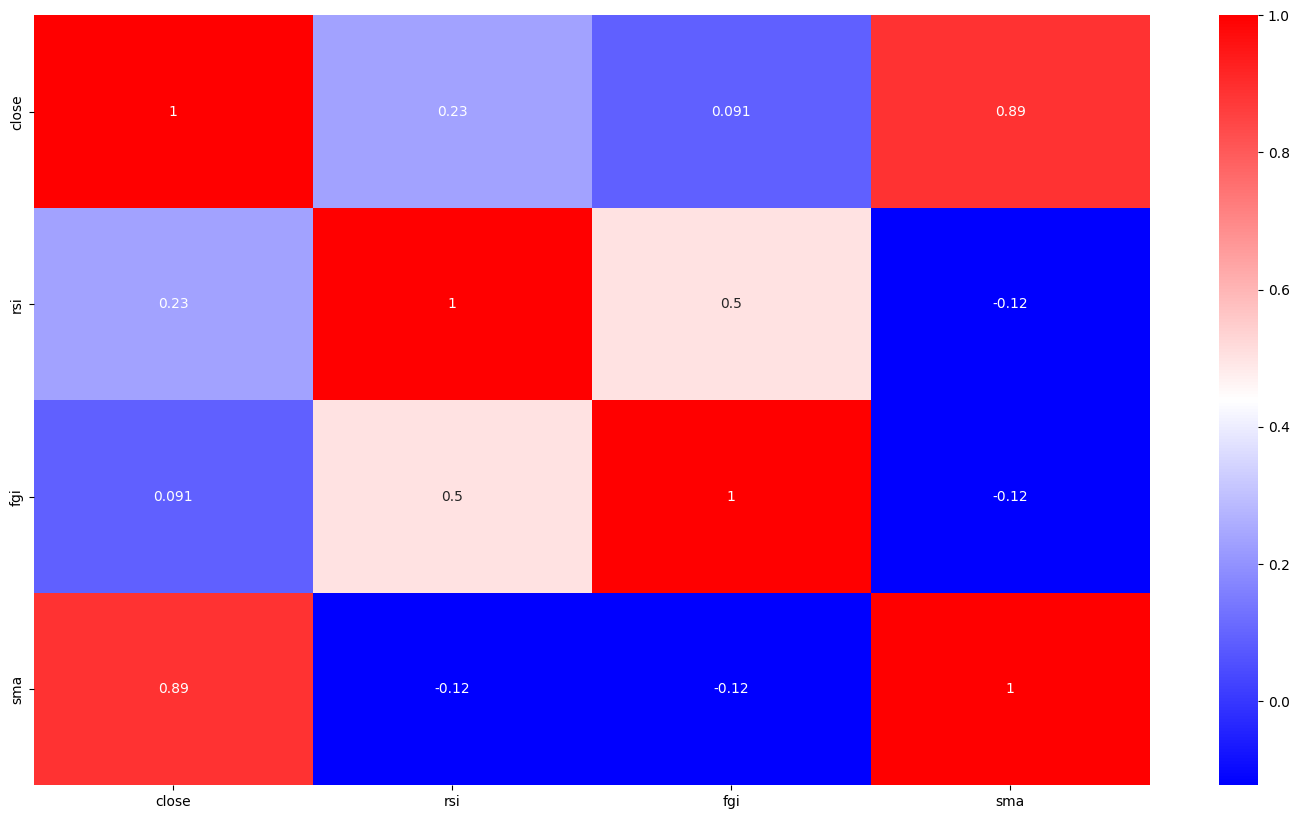

In [40]:
def corr_matrix(df):
  df = df[['close', 'rsi', 'fgi', 'sma']]
  corr_df = df.corr(method='pearson')
  plt.figure(figsize = (18, 10))
  sns.heatmap(corr_df, cmap = 'bwr', annot=True)
  plt.show()

corr_matrix(df)

TypeError: 'Axes' object is not subscriptable

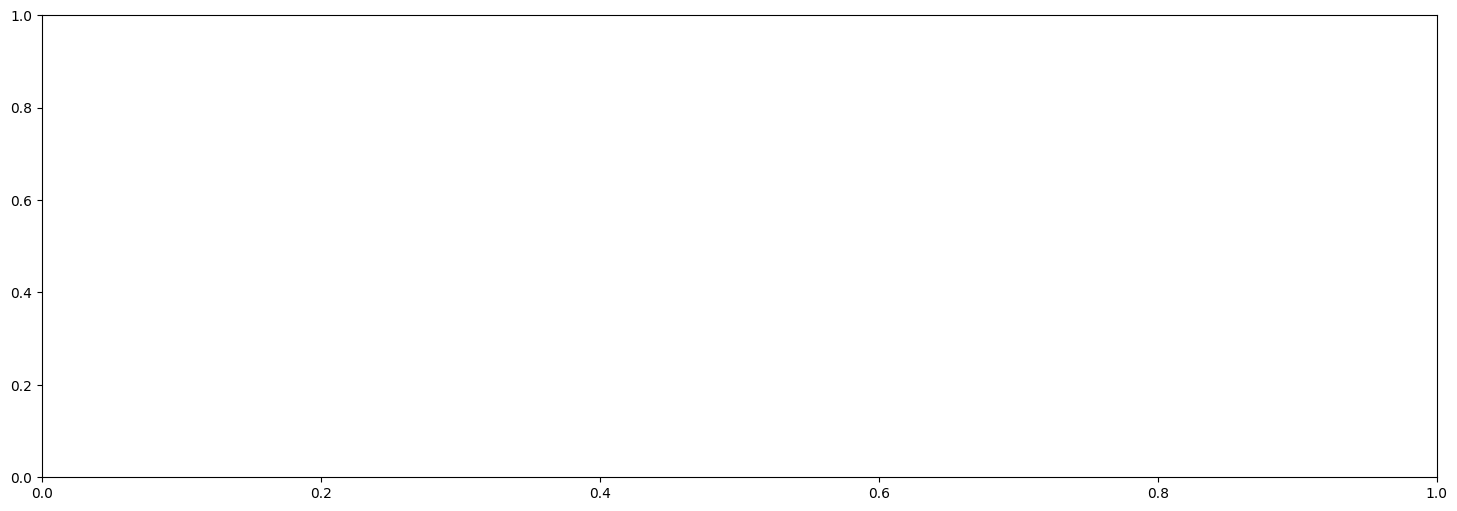

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
df[['close', 'sma']].plot(ax=axes[0], title='Close Prices & MA', xlabel='Date', ylabel='Value')
df[['fgi', 'rsi']].plot(ax=axes[1], title='RSI & FGI', xlabel='Date')
plt.show()